Link to GitHub:

https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language

In [50]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
import warnings
from gensim import corpora, models
from gensim.models import CoherenceModel
import csv
from liwc import LIWC
import warnings

# Load Raw Data

In [108]:
df=pd.read_csv("../data/labeled_data.csv")
df.drop(df.columns[[0]], axis=1,inplace=True)
print(df.iloc[:5,:])
print(df.shape)

   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
(24783, 6)


# Data Pre-processing 

In [109]:
stopwords = nltk.corpus.stopwords.words("english")
txt=df.iloc[:,5]
tweet=txt.copy(deep=True)
#tweet=pd.DataFrame(tweet)
#transform to lower case
tweet=tweet.str.lower()
#remove punctuation
remove = str.maketrans('','',string.punctuation) 
tweet = tweet.str.translate(remove)
#word tokenize and remove stopwords
#remove digit and excessive whitespace
for i in range(tweet.shape[0]):
    text=tweet[i]
    text1=''.join([ch+" " for ch in text.split() if ch not in ' 123456789'])
    text2=''.join([word+" " for word in text1.split() if word not in stopwords])
    tweet[i]=text2
info=re.compile('[0-9|rt]')
tweet=tweet.apply(lambda x: info.sub('',x))
print(tweet[:5])

0     mayasolovely woman shouldn complain cleaning ...
1     mleew boy das coldyga dwn bad cuffin da hoe s...
2     ukindofband dawg  sbabylife eve fuck bich sa ...
3                  cgandeson vivabased look like anny 
4     shenikaobes shi hea migh ue migh fake bich ol...
Name: tweet, dtype: object


## Do more process of replacing:
    1) urls
    2) lots of whitespace with one instance
    3) mentions

In [110]:
def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text
for i in range(tweet.shape[0]):
    text=tweet[i]
    text1=preprocess(text)
    tweet[i]=text1
print(tweet[:5])

0     mayasolovely woman shouldn complain cleaning ...
1     mleew boy das coldyga dwn bad cuffin da hoe s...
2     ukindofband dawg sbabylife eve fuck bich sa c...
3                  cgandeson vivabased look like anny 
4     shenikaobes shi hea migh ue migh fake bich ol...
Name: tweet, dtype: object


# Feature Extraction
## 1.LIWC

In [ ]:
#run LIWC on the whole df

LIWC_list=[]
for i in range(len(tweet)):
    L = LIWC()
    length, matched, labels = L.classify(tweet[i].split())
    LIWC_list.append(L.readable(labels))
LIWC_list
#update preprocessed text to original df
df.tweet=tweet
hateSpeech=df[df['hate_speech'] ==3]["tweet"].reset_index(drop=True)
#it is the list of hate speech
LIWC_list1=[]
for i in range(len(hateSpeech)):
    L = LIWC()
    length, matched, labels = L.classify(hateSpeech[i].split())
    LIWC_list1.append(L.readable(labels))
LIWC_list1
#function that add dictionary
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = value +dict1[key]
   return dict3
#add those dic together
hate_dic=LIWC_list1[0]
for i in range(len(LIWC_list1)):
    hate_dic=mergeDict(hate_dic, LIWC_list1[i])
hate_dic.keys()
#find hate_relevent key by analyzing hate speech
relevent_key=[k for k, v in hate_dic.items() if v > 50]
#build dataframe with relevent columns
LIWC_df=pd.DataFrame(data=LIWC_list, index=None, columns=None, dtype=None, copy=False)[relevent_key]
LIWC_df.shape

In [34]:
LIWC_df = LIWC_df.fillna(0)
LIWC_df.to_csv("../data/LIWC.csv", index = False)

## 2.Skip-gram

### Average len of tweet

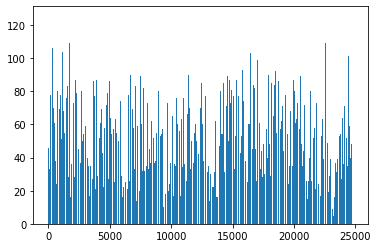

50.66953153371263


In [111]:
#average len of tweet
avg=0
num=[]
x=[x for x in range(24783)]
for n in range(tweet.shape[0]):
    avg+=len(tweet[n])
    num.append(len(tweet[n]))
avg=avg/(tweet.shape[0])
plt.bar(x,num)
plt.show()
print(avg)

In [112]:
word=[]
for i in range(tweet.shape[0]):
    w=tweet[i].replace('\n','').rstrip()
    w1=w.split(" ")
    word.append(w1)
def flatten(seq):
    s=str(seq).replace('[', '').replace(']', '') 
    return [eval(x) for x in s.split(',') if x.strip()] 
word=[x for x in flatten(word)]
word=[x for x in word if x!='']
len(word)

212672

Create the input data for word2vec

In [113]:
for i in range(len(tweet)):
    doc=tweet[i]
    doc=doc.split(" ")
    doc=[x for x in doc if x!='']
    tweet[i]=doc
tweet[:5]

0    [mayasolovely, woman, shouldn, complain, clean...
1    [mleew, boy, das, coldyga, dwn, bad, cuffin, d...
2    [ukindofband, dawg, sbabylife, eve, fuck, bich...
3             [cgandeson, vivabased, look, like, anny]
4    [shenikaobes, shi, hea, migh, ue, migh, fake, ...
Name: tweet, dtype: object

word2vec by skip-gram

In [114]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
model = Word2Vec(size=100, workers=5,sg=1)  #dimension is 200, consider 5 words, using skip-gram
model.build_vocab(tweet)
model.train(tweet,total_examples = model.corpus_count,epochs = 5)


(721048, 1063360)

In [124]:
warnings.filterwarnings("ignore")
word_vec=[]
#average each word vector to get the vector of a single tweet
for i in range(len(tweet)):
    sum1=0
    for w in tweet[i]:
        try:
            sum1+=model[w]
        except:
            continue
    avg=sum1/(len(tweet[i]))
    avg=list(avg)
    word_vec.append(avg)
word_vec[:5]     

TypeError: 'float' object is not iterable

In [119]:
len(word_vec)

24783

In [106]:
word_vec_array=np.array(word_vec)
word_vec_l=np.reshape(word_vec_array[0],(1,100))
for i in range(len(tweet)):
    array=np.reshape(word_vec_array[i],(1,100))
    word_vec_l=np.r_[word_vec_l,array]
word_vec_l

IndexError: index 598 is out of bounds for axis 0 with size 598

In [55]:
word_vec_lt=word_vec_l
word_vec_lt=np.delete(word_vec_lt,0,0)
word_vec_lt.shape

(598, 100)

In [120]:
#save this array as csv

f = open('../data/word2vec_skip.csv', 'w')
a = csv.writer(f)
a.writerows(word_vec_lt)
f.close()

In [122]:
np.savetxt('../data/word2vec_skip1.csv', word_vec_lt, delimiter = ',')  

## 3.LDA

construct dic for LDA 

In [92]:
dictionary = corpora.Dictionary(tweet)
corpus = [dictionary.doc2bow(words) for words in tweet]

Find the optimal topic numbers

In [101]:
for i in [50, 60, 70, 80]:
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda, texts=tweet, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    


Coherence Score:  0.38819085916417634

Coherence Score:  0.42194391540606735

Coherence Score:  0.43920979717599234

Coherence Score:  0.41266646537218143


In [102]:
# lda model, num_topics is the number of topic
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=70)
# print 5 words for each topic 
for topic in lda.print_topics(num_words=5):
    print(topic)
# topic infer
lda_infer= lda.inference(corpus)
print(lda.inference(corpus))

(64, '0.200*"man" + 0.074*"show" + 0.043*"eveyhing" + 0.039*"bich" + 0.028*"one"')
(68, '0.147*"n" + 0.121*"us" + 0.066*"wo" + 0.047*"done" + 0.043*"bae"')
(55, '0.165*"alk" + 0.130*"bou" + 0.033*"kid" + 0.029*"youve" + 0.027*"bich"')
(30, '0.122*"bee" + 0.108*"yellow" + 0.067*"bich" + 0.056*"ied" + 0.043*"ask"')
(23, '0.134*"fa" + 0.128*"new" + 0.077*"bich" + 0.063*"die" + 0.046*"ype"')
(13, '0.108*"geing" + 0.088*"black" + 0.072*"nohing" + 0.057*"h" + 0.051*"kids"')
(67, '0.141*"gil" + 0.103*"call" + 0.087*"wie" + 0.044*"like" + 0.042*"days"')
(10, '0.087*"sa" + 0.063*"song" + 0.061*"had" + 0.047*"sick" + 0.047*"pussies"')
(37, '0.118*"gonna" + 0.056*"fee" + 0.043*"im" + 0.043*"use" + 0.037*"somebody"')
(3, '0.113*"lile" + 0.110*"bich" + 0.096*"always" + 0.043*"wish" + 0.043*"hai"')
(39, '0.077*"hi" + 0.068*"niggah" + 0.064*"gon" + 0.064*"onigh" + 0.062*"back"')
(11, '0.107*"alking" + 0.079*"well" + 0.074*"side" + 0.041*"ges" + 0.037*"calling"')
(8, '0.146*"look" + 0.116*"like" + 0.0

In [103]:
print(lda_infer[0].shape)

(24783, 70)


In [104]:
lda_infer = pd.DataFrame(lda_infer[0])
lda_infer.to_csv("../data/lda_infer.csv", index = False)